# K Nearest Neighbors

We use the K Nearest Neighbors model. We import KNeighborsClassifier from sklearn.neighbors.

In [9]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#### Loading the data

In [4]:
path = '/Users/louispht/Documents/git_projects/news_classifier/Data cleaning/Pickles/'

# Dataframe
with open(path + 'df_all.pickle', 'rb') as data:
    df_all = pickle.load(data)

# features_train
with open(path + 'features_train.pickle', 'rb') as data:
    features_train = pickle.load(data)

# y_train
with open(path + 'y_train.pickle', 'rb') as data:
    y_train = pickle.load(data)

# features_test
with open(path + 'features_test.pickle', 'rb') as data:
    features_test = pickle.load(data)

# y_test
with open(path + 'y_test.pickle', 'rb') as data:
    y_test = pickle.load(data)
    
# df_test
with open(path + 'df_test.pickle', 'rb') as data:
    df_test = pickle.load(data)
    
# df_all_le
with open(path + 'df_all_le.pickle', 'rb') as data:
    df_all_le = pickle.load(data)

### Cross Validation

In order to get the best model, we use cross validation to select some hyperparameters in the knn model.

In [6]:
hyper_knnc =KNeighborsClassifier()

print('Hyperparameters:\n')
print(hyper_knnc.get_params())

Hyperparameters:

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


We check the documentation to understand each parameter. 

In [8]:
#help(KNeighborsClassifier())

We will only do a hypertuning on 'n_neighbords', so it is worth doing a Grid Search Cross Validation. 

In [21]:
# Create the parameter grid 
n_neighbors = list(range(1,500, 5))

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 480.6min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=42, test_size=0.33, train_size=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291,...401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476, 481, 486, 491, 496]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [22]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 21}

The mean accuracy of a model with these hyperparameters is:
0.816834520593


We save the best model.

In [24]:
#Save the best model
best_knnc = grid_search.best_estimator_

In [25]:
best_knnc

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=21, p=2,
           weights='uniform')

We fit our model.

In [26]:
best_knnc.fit(features_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=21, p=2,
           weights='uniform')

In [27]:
#predictions 
knnc_pred = best_knnc.predict(features_test)

### Performance Analysis

We use confusion matrix, the classification report and accuracy to analyse the performance.

In [29]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(y_train, best_knnc.predict(features_train)))

The training accuracy is: 
0.837697608431


In [30]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, knnc_pred))

The test accuracy is: 
0.810461956522


The two scores are fairly closed, indicating that overfitting is maybe less of an issue than with svc.

In [31]:
# Classification report
categories = {'actualite':0, 'sports':4, 'international':3, 'affaires':1, 'culture':2}
print("Classification report")
print(classification_report(y_test,knnc_pred, target_names=categories))

Classification report
               precision    recall  f1-score   support

    actualite       0.68      0.81      0.74       342
       sports       0.82      0.77      0.79       243
international       0.86      0.73      0.79       274
     affaires       0.77      0.83      0.80       220
      culture       0.94      0.89      0.91       393

  avg / total       0.82      0.81      0.81      1472



Again actualites is performing the worst, for the reasons stated in the support_vector_machine document. The scores are very similar to the support_vector_machine model. 

#### Confusion matrix

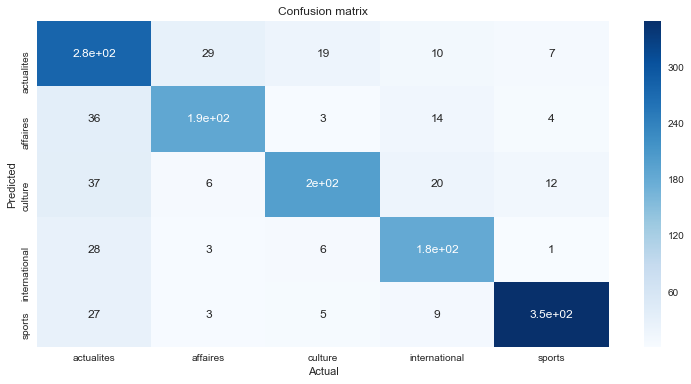

In [32]:
#Confusion matrix
aux_df = df_all_le[['category', 'label_enc']].drop_duplicates().sort_values('category')
conf_matrix = confusion_matrix(y_test, knnc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['category'].values, 
            yticklabels=aux_df['category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

### Saving the model

In [33]:
d = {
     'Model': 'KNNC',
     'Training Set Accuracy': accuracy_score(y_train, best_knnc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(y_test, knnc_pred)
}

df_models_knnc = pd.DataFrame(d, index=[0])

In [34]:
df_models_knnc

,Model,Training Set Accuracy,Test Set Accuracy
0,KNNC,0.837698,0.810462


In [35]:
with open('Models/best_knnc.pickle', 'wb') as output:
    pickle.dump(best_knnc, output)
    
with open('Models/df_models_knnc.pickle', 'wb') as output:
    pickle.dump(df_models_knnc, output)

### Looking at some fail classification

In [36]:
from IPython.display import display
id_to_category = dict(aux_df[['label_enc', 'category']].values)
for predicted in aux_df.label_enc:
    for actual in aux_df.label_enc:
        if predicted != actual and conf_matrix[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_matrix[actual, predicted]))
            display(df_test.loc[(y_test == actual) & (knnc_pred == predicted)][['title', 'category', 'content']].sample(10))
            print('')

'affaires' predicted as 'actualites' : 36 examples.


,title,category,content
399,Quatre formations à découvrir pour préparer le...,affaires,"L’incertitude liée à la COVID-19 demeure, et p..."
1064,Prenez l’assurance voyage même au Canada,affaires,"Pandémie oblige, les Québécois voyagent plus q..."
1066,La pénurie est de retour,affaires,Le Québec a beau être confronté à un taux de c...
1108,Les jeux de mots du Pho King Bon analysés,affaires,Un inspecteur de l’Office québécois de la lang...
412,Une Charte de l’aluminium réclamée par l’indus...,affaires,L’industrie de l’aluminium réclame l’adoption ...
1048,"Le don d’organes, un héritage précieux",affaires,"Au printemps, j’étais en train de finaliser le..."
1088,Pandémie: 59 programmes d’aide en 56 jours,affaires,Justin Trudeau a fait pleuvoir les milliards d...
371,Protection du dossier de crédit : TransUnion o...,affaires,(Québec) Une des grandes agences de crédit est...
403,Réinventer ses baisers sucrés en temps de crise,affaires,Baiser velouté crée des tables à desserts thém...
297,"Ottawa a « économisé » 14,5 milliards en péréq...",affaires,(Ottawa) Le directeur parlementaire du budget ...



'culture' predicted as 'actualites' : 37 examples.


,title,category,content
695,La fréquentation du Louvre dégringole,culture,(Paris) Faute de visiteurs extraeuropéens à ca...
1454,Les spectacles de Guy Nantel dénoncés,culture,Le Parti québécois mérite un chef à temps plei...
736,Une fille pour Katy Perry et Orlando Bloom,culture,(Montréal) Katy Perry a donné naissance à une ...
745,J Balvin est atteint de la COVID-19,culture,Le chanteur J Balvin a révélé jeudi qu’il est ...
741,Britney Spears ne veut plus être sous tutelle ...,culture,(Los Angeles) La vedette américaine de la pop ...
746,COVID-19: Ryan Reynolds lance un message aux j...,culture,(Vancouver) Ryan Reynolds a répondu à l’appel ...
1441,Imagine Van Gogh arrive à Québec le 18 juillet,culture,"Avec un retard de trois semaines, causé par le..."
694,Un tableau de Frans Hals volé pour la 3e fois,culture,(La Haye) Un tableau du grand maître de l’âge ...
1360,Une vidéo frappante de sa perte de cheveux,culture,Alyssa Milano a exhorté ses fans sur les résea...
1446,Pas de kiosques au Salon du livre de Montréal,culture,Les amateurs de littérature peuvent respirer: ...



'international' predicted as 'actualites' : 28 examples.


,title,category,content
1024,Le compte Twitter de Narendra Modi piraté,international,"Le compte Twitter du premier ministre indien, ..."
973,Le plus vieux couple marié au monde,international,"Julio Cesar Mora et sa femme, Waldramina Maclo..."
965,Légère baisse des incendies en Amazonie en août,international,Le nombre d’incendies en Amazonie brésilienne ...
268,Royaume-Uni: «confusion» autour des quarantain...,international,(Londres) Le gouvernement britannique a reconn...
1044,Les manchots menacés par le ravitaillement en...,international,"PORT ELIZABETH | Dans le vacarme des moteurs, ..."
1006,Une fillette s’envole avec un cerf-volant,international,Une fillette de 3 ans a sans aucun doute eu la...
966,La Havane sous couvre-feu pour deux semaines,international,Un couvre-feu de deux semaines entre en vigueu...
200,La chloroquine aurait pu sauver «beaucoup de v...,international,(Brasilia) Le président brésilien Jair Bolsona...
1002,Tentative d’assassinat contre Raif Badawi,international,Le blogueur saoudien Raif Badawi a été victime...
1037,RDC: fin de l’épidémie de rougeole,international,Le ministre congolais de la Santé a déclaré ma...



'sports' predicted as 'actualites' : 27 examples.


,title,category,content
1242,Estephan pourrait devoir patienter,sports,Le médecin de la Santé publique Richard Massé...
572,Confinement prolongé: «Un grand manque de resp...,sports,Toujours dans l’attente d’un retour malgré l’e...
1312,De coach de l’élite à aide de service,sports,Après avoir passé du temps de qualité en famil...
1323,Saison terminée dans les stations de ski,sports,L’Association des stations de ski du Québec (A...
583,Ski : le Congrès électif de la Fédération inte...,sports,(Paris) Le Congrès de la Fédération internatio...
1337,La PDG de Vélo Québec annonce son départ,sports,La pratique du vélo n’a jamais été aussi popul...
559,Sports de combat : feu vert pour les entraînem...,sports,Laissés en plan depuis le déconfinement des sp...
1234,Nouvelle saison de chasse du chevreuil,sports,"Depuis le temps qu’elle était attendue, la fin..."
573,Relance de la boxe au Québec: Eye of the Tiger...,sports,(Montréal) Le promoteur de boxe Eye of the Tig...
1230,Une fin de semaine consacrée à la relève,sports,La toute première fin de semaine de chasse des...



'actualites' predicted as 'affaires' : 29 examples.


,title,category,content
125,Crouler sous les emballages,actualites,Les boîtes de prêt-à-cuisiner livrées à domici...
891,Le Canada s’oppose à des forages en Alaska,actualites,Le Canada a donné son soutien jeudi à des grou...
841,Aurora Cannabis réduit sa présence au Québec,actualites,Le fournisseur de la Société québécoise du can...
811,Les chaussées préservées en raison de la COVI...,actualites,Même si certains camions ont pu transporter de...
838,Second Cup se lance dans le cannabis,actualites,TORONTO | Second Cup a ouvert sa première bout...
158,Des Autochtones se joignent à leurs frères de ...,actualites,Des Autochtones et des écologistes canadiens s...
4,L'affluence dans les transports en commun en c...,actualites,(Ottawa) De nouvelles statistiques montrent qu...
843,Lennox Lewis se lance à son tour dans le cann...,actualites,"À l’image de son ancien rival Mike Tyson, l’ex..."
12,Les « Snowbirds » sont autorisés à voler de no...,actualites,(Ottawa) L’Escadron de démonstration aérienne ...
837,Pas encore de politique sur la fixation des p...,actualites,Contrairement à la Société des alcools du Québ...



'actualites' predicted as 'culture' : 19 examples.


,title,category,content
916,Un restaurant aux jeux de mots à caractère se...,actualites,Le propriétaire d’un nouveau bistro vietnamien...
172,Projet DOMe: détecter les météorites «québécoi...,actualites,"Elles viennent de l’espace, tombent au sol… et..."
168,À petites doses,actualites,Les gaz d’échappement des modules se posant su...
796,Les choses «sont en train de changer»,actualites,"Invitées au micro de Caroline St-Hilaire, Anne..."
136,Le dernier magasin Blockbuster se loue pour de...,actualites,(Los Angeles) Le dernier magasin Blockbuster d...
913,Une bière brassée avec le houblon de votre ja...,actualites,Vous faites pousser du houblon dans votre pota...
914,Véro contre les coquerelles,actualites,Je ne sais pas ce qui me choque le plus dans c...
889,"Intello et timide, écrasée par les responsabi...",actualites,"Venise | Derrière l’égérie du climat, une ado ..."
861,Les tigres de papier,actualites,Richard Martineau notait qu’une partie de notr...
134,Un «sorcier» de la Nouvelle-Zélande se souvien...,actualites,Bien avant de devenir le Sorcier de la Nouvell...



'actualites' predicted as 'international' : 10 examples.


,title,category,content
28,Ottawa maintient la pression sur le régime Lou...,actualites,(Ottawa) Le Canada laisse entendre qu’il est p...
14,Boeing abattu en Iran : le Canada exige de Téh...,actualites,(Ottawa) Les ministres canadiens des Affaires ...
135,Un restaurant chinois s’excuse d’avoir pesé se...,actualites,"(Pékin) Un restaurant de Changsha, dans le cen..."
15,Avion abattu: l’Iran souhaite amorcer les pour...,actualites,(Ottawa) Le gouvernement iranien lancera en oc...
70,Cinq cadavres retrouvés dans une maison d’Osha...,actualites,(Oshawa) L’auteur présumé d’un carnage qui a f...
131,Un sanglier «voleur» menacé par les chasseurs,actualites,(BERLIN) Des sangliers sèment la panique à Ber...
790,Berlin critique l’appel de Trump à voter deux...,actualites,Le chef de la diplomatie allemande a accusé di...
133,Un Australien frappe un requin à coups de poin...,actualites,(Sydney) Un Australien est devenu un « héros »...
902,D'étranges lignes blanches formées sur une pl...,actualites,De mystérieuses lignes blanches sont apparues ...
890,Des millions de litres dans le Saint-Maurice,actualites,Trois-Rivières continue de déverser ses eaux u...



'affaires' predicted as 'international' : 14 examples.


,title,category,content
353,Fox News bientôt disponible en streaming à l’é...,affaires,(Washington) La société Fox Corp du magnat Rup...
298,"Décès de David Graeber, figure de proue d’Occu...",affaires,(New York) L’anthropologue américain David Gra...
338,Chine: Apple clarifie sa politique sur la libe...,affaires,(Paris) Accusé par des ONG et investisseurs d’...
348,Manifestations à Kenosha: Zuckerberg reconnaît...,affaires,(Washington) Facebook a commis une erreur en n...
336,Le Pentagone réaffirme son choix de Microsoft ...,affaires,(San Francisco) Le ministère de la Défense amé...
341,Verizon investit près de 2 milliards supplémen...,affaires,"(San Francisco) Verizon va dépenser près de 1,..."
358,Meredith Kopit Levien deviendra PDG du New Yor...,affaires,(New York) Déjà numéro deux opérationnelle du ...
1102,Amazon interdit l’importation de semences,affaires,Amazon a interdit l’importation de semences pr...
343,Donald Trump ne lâche rien sur la vente de TikTok,affaires,(San Francisco) Donald Trump a réitéré mardi s...
293,La pandémie pourrait donner le « baiser de la ...,affaires,(Genève) La pandémie de coronavirus a accru la...



'culture' predicted as 'international' : 20 examples.


,title,category,content
1357,Harry et Meghan dans leur nouvelle maison,culture,"LOS ANGELES | Le prince Harry et son épouse, M..."
739,Scandale des universités: l’actrice Lori Lough...,culture,(New York) « Je comprends que j’ai contribué à...
1468,Dieudonné banni de Facebook et Instagram,culture,PARIS | Le groupe Facebook a annoncé lundi avo...
697,Le passé esclavagiste du fondateur du British ...,culture,(Londres) Le British Museum a retiré de son pi...
733,Le monde selon Adib,culture,(Paris) La chaîne YouTube du polémiste françai...
702,Le Met de New York rouvrira au public le 29 août,culture,"(New York) Deux grands musées de New York, le ..."
1355,COVID-19: le message poignant de Sharon Stone,culture,Sharon Stone s’est insurgée contre celles et c...
732,La chaîne YouTube de Dieudonné supprimée,culture,(Paris) La chaîne YouTube du polémiste françai...
724,Dieudonné interdit de Facebook et Instagram,culture,(Paris) Ses saillies antisémites ne trouveront...
684,Propos sur les personnes transgenres: J. K. Ro...,culture,(Londres) L’écrivaine britannique J. K. Rowlin...



'culture' predicted as 'sports' : 12 examples.


,title,category,content
638,Dylan Phillips : épopée néo-classique ★★★★,culture,"Undercurrents, premier album solo du multi-ins..."
1396,Elle lance une chanson composée avec ses fans,culture,Tout ce que touche Roxane Bruneau semble se tr...
652,"Attention, téléréalité très touchante !",culture,(Toronto) Les Américains auront l’occasion de ...
646,Stricly Come Dancing forme un premier couple d...,culture,(Londres) Le concours de danse Stricly Come Da...
769,Robert Pattinson positif à la COVID-19 ? Le to...,culture,"(Los Angeles) Le tournage de The Batman, derni..."
1354,L’acteur ne l’a pas trouvé drôle!,culture,"Johana Agurto, une enseignante chilienne au ch..."
651,Transplant avec Laurence Lebœuf diffusée aux É...,culture,(Toronto) Les Américains auront l’occasion de ...
629,Un album pour le retour en ondes de La Voix,culture,(Montréal) Pour souligner le retour en ondes d...
1389,Rita Baga mord la poussière,culture,Le titre de nouvelle Reine du Nord a glissé en...
1452,Le Comiccon de Montréal reporté en 2021,culture,MONTRÉAL | Le Comiccon 2020 de Montréal a été ...


Overall, the misclassifications are different from our svc model. A lot of the articles which really could be part of two different categories seem to have been misclassified by both models. For example, the article titled 'Un Australien frappe un requin...' was misclasified as an international article in both cases. 